# Environment Setup

In [1]:
!pip install gpytoolbox

In [1]:
import gpytoolbox as gpy
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Dataset

In [2]:
from torchvision import transforms

def pcmnist(batch_size=16, size=128, num_samples=300, path_to_data='mnist_data/', augment=False, label=None):
    """PointCloudMNIST dataloader.

    Parameters
    ----------
    batch_size : int

    size : int
        Size (height and width) of each image. Default is 28 for no resizing.

    path_to_data : string
        Path to MNIST data files.
    """
    all_transforms = transforms.Compose([
        transforms.Resize(size),
    ])

    train_data = utils.PointCloudMNISTDataset(path_to_data, train=True, download=True,
                                transform=all_transforms, num_samples=num_samples,random_seed=2, augment=augment)

    if label is not None:
        train_idx = train_data.targets == label
        train_data.data = train_data.train_data[train_idx]
        train_data.targets = train_data.train_labels[train_idx]    

    test_data = utils.PointCloudMNISTDataset(path_to_data, train=False,
                               transform=all_transforms, num_samples=num_samples,random_seed=2, augment=False)
    
    if label is not None:
        test_idx = test_data.targets == label
        test_data.data = test_data.test_data[test_idx]
        test_data.targets = test_data.test_labels[test_idx]    

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

/host/home/jpvt/Documents/SGI/repos/sampling-surfaces/utils/data/pcmnist.py:104: RuntimeWarning: invalid value encountered in divide
  vecs /= np.linalg.norm(vecs, axis=1)[:,None]


(500, 2) (500,)


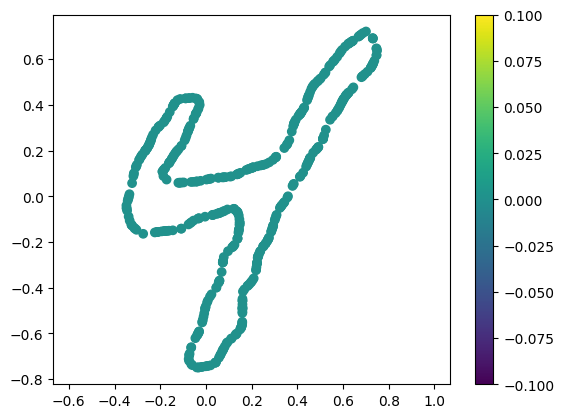

(500, 2) (500,)


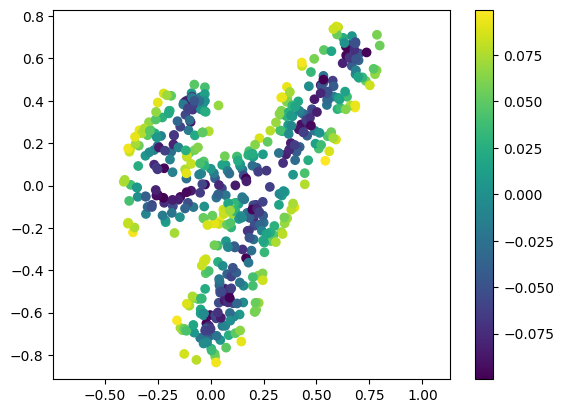

tensor([4, 2, 4, 5, 1, 4, 9, 2, 2, 3, 3, 8, 2, 1, 9, 4, 0, 8, 7, 2, 9, 3, 6, 1,
        5, 8, 8, 7, 5, 5, 7, 8, 5, 0, 5, 7, 3, 6, 9, 2, 0, 1, 2, 5, 4, 7, 7, 3,
        2, 2, 6, 9, 7, 0, 6, 3, 5, 8, 8, 4, 4, 4, 4, 2])


In [3]:
BATCH_SIZE=64
IMG_SIZE=128
SAMPLE_SIZE = 500
train_dataloader, test_dataloader = pcmnist(batch_size=BATCH_SIZE, size=IMG_SIZE, num_samples=SAMPLE_SIZE)
#_, test_dataloader = pcmnist(batch_size=BATCH_SIZE, size=IMG_SIZE, num_samples=SAMPLE_SIZE)
i = 0
for Xs, Ys, normals, target in test_dataloader:
  X = Xs[0].numpy()
  Y = Ys[0].numpy()
  print(X.shape, Y.shape)

  plt.scatter(X[:,0],X[:,1], c=Y)
  plt.axis("equal")
  plt.colorbar()
  plt.show()

  #X, Y = utils.data.generate_pts_from_normals(X, normals[0].numpy(), n_points=X.shape[0]*2)
  X, Y = utils.data.generate_pts_from_normals(X, normals[0].numpy())

  print(X.shape, Y.shape)

  plt.scatter(X[:,0],X[:,1], c=Y)
  plt.axis("equal")
  plt.colorbar()
  plt.show()
  print(target)
  i +=1
  
  if i == 1:
    break

## Utils

In [4]:
def plot_neural_process(xs, ys, mu, std, X,y, grid_size, plot_sample=1):
    """
    Plot Mean and Std of Neural Process side by side.

    Parameters:
    - xs: x grid values
    - ys: y grid values
    - mu: mean tensor values
    - std: standard deviation tensor values
    - X: scatter plot data
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    X = X.cpu()
    y = y.cpu().numpy()
    print(X.shape)
    # Mean of Neural Process plot
    axes[0].set_title("Mean of Neural Process")
    c1 = axes[0].pcolormesh(xs, ys, mu.cpu().view((grid_size,grid_size)).detach().numpy(), shading='gouraud', cmap="viridis")
    fig.colorbar(c1, ax=axes[0])
    axes[0].contour(xs, ys, mu.cpu().view((grid_size,grid_size)).detach().numpy(), levels=[0], colors='black')
    axes[0].scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c="k")

    # Std of Neural Process plot
    axes[1].set_title("Std of Neural Process")
    c2 = axes[1].pcolormesh(xs, ys, std.cpu().view((grid_size,grid_size)).detach().numpy(), shading='gouraud', cmap="plasma")
    fig.colorbar(c2, ax=axes[1])
    axes[1].scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c="k")
    
    plt.tight_layout()
    plt.show()

    if plot_sample > 0:
        m = torch.distributions.normal.Normal(mu, std)
        for i in range(plot_sample):
            sample = m.rsample().detach()

            plt.title("Sample of Neural Process")
            plt.pcolormesh(xs,ys,sample.cpu().reshape((grid_size,grid_size)).detach().numpy(),shading='gouraud',cmap="plasma")
            plt.colorbar()
            plt.contour(xs,ys,sample.cpu().reshape((grid_size,grid_size)).detach().numpy(),levels=[0], colors='black')
            plt.scatter(X[0][:,0].numpy(), X[0][:,1].numpy(),  c="k")
            plt.tight_layout()
            plt.show()

In [5]:
def get_context_and_target(x, normals, n_context, n_target):
    # Ensure n_context is less than or equal to n_target
    assert n_context <= n_target, "n_context should be less than or equal to n_target"

    batch_size = x.size(0)
    
    x_context_list, y_context_list, x_target_list, y_target_list = [], [], [], []
    
    for b in range(batch_size):
        # Sample n_target indices from the range [0, x.size(1)-1]
        target_indices = torch.randperm(x.size(1))[:n_target]

        # Get x_target and y_target values for the batch
        x_target_b = x[b, target_indices]
        normals_target_b = normals[b, target_indices]

        # From the n_target indices, subsample n_context indices
        context_indices = torch.randperm(n_target)[:n_context]

        # Get x_context and y_context values for the batch
        #print(context_indices.shape, context_indices)
        #print(x_target_b.shape, y_target_b.shape)
        x_context_b = x_target_b[context_indices]
        normals_context_b = normals_target_b[context_indices]

        x_context_b, y_context_b = utils.data.generate_pts_from_normals(x_context_b.cpu().numpy(), normals_context_b.cpu().numpy(), n_points=x_context_b.shape[0]*2)
        x_context_b, y_context_b = torch.tensor(x_context_b, dtype=torch.float32), torch.tensor(y_context_b,dtype=torch.float32)

        x_target_b, y_target_b = utils.data.generate_pts_from_normals(x_target_b.cpu().numpy(), normals_target_b.cpu().numpy(), n_points=x_target_b.shape[0]*2)
        x_target_b, y_target_b = torch.tensor(x_target_b, dtype=torch.float32), torch.tensor(y_target_b,dtype=torch.float32)
        
        x_context_list.append(x_context_b)
        y_context_list.append(y_context_b)
        x_target_list.append(x_target_b)
        y_target_list.append(y_target_b)
    
    x_context = torch.stack(x_context_list)
    y_context = torch.stack(y_context_list)
    x_target = torch.stack(x_target_list)
    y_target = torch.stack(y_target_list)

    return x_context, y_context, x_target, y_target

In [6]:
def test(model, dataloader, writer=None, plot=True, global_step=None, seed=42, title='', size=50, grid_size=100, use_normals=False,
        predict_twice=True):
    model.eval()
    model.to(device)
    with torch.no_grad():
        Xs, Ys, _, labels = next(iter(dataloader))
        context_x, context_y, label = Xs[0], Ys[0], labels[0]
        context_indices = torch.randperm(context_x.size(0))[:size]
        context_x = torch.Tensor(context_x[context_indices]).reshape((1,size,2)).to(device)
        context_y = torch.Tensor(context_y[context_indices]).reshape((1,size,1)).to(device)
        #print(context_x.shape, context_y.shape)
        
        # Create a set of target points corresponding to entire [-pi, pi] range
        xs = np.linspace(-1,1,grid_size)
        ys = np.linspace(-1,1,grid_size)
        Xs,Ys = np.meshgrid(xs,ys)
        Xs = Xs.flatten()
        Ys = Ys.flatten()
        grid = np.vstack((Xs,Ys)).T
        target_x = torch.Tensor(grid).reshape(1,grid_size**2,2).to(device)

        #print(context_x.shape, context_y.shape, target_x.shape)
        y_pred, kl, loss, z, y_std = model(context_x, context_y, target_x)

        # if writer is not None:
        #     writer.add_scalar('val/loss', loss, global_step=global_step)
        #     writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
        #     writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
        #     writer.add_scalar('val/kl', kl.mean(), global_step=global_step)

        if plot:
            print("Original Label: ", label)
            plot_neural_process(xs,ys,y_pred,y_std, context_x, context_y, grid_size, plot_sample=0)
            if predict_twice:
                y_pred2, kl, loss, z, y_std = model(context_x, context_y, target_x, sample=True)
                plot_neural_process(xs,ys,y_pred2,y_std, context_x, context_y, grid_size, plot_sample=0)

            if writer is not None:
                writer.add_figure('test', global_step=global_step, close=False)
            plt.show()

    return y_pred, kl, loss, y_std

In [7]:
def test_progress(model, dataloader, writer=None, plot=True, global_step=None, seed=42, title='', sizes=[50,100], grid_size=100, use_normals=False, multiple=10):
    model.eval()
    model.to(device)
    with torch.no_grad():
        X, Y, normals, labels = next(iter(dataloader))
        for size in sizes:
            context_x, context_y, normal, label = X[0], Y[0],normals[0], labels[0]
            context_indices = torch.randperm(context_x.size(0))[:size]

            # context_x, context_y = utils.data.generate_pts_from_normals(context_x[context_indices].cpu().numpy(), normal[context_indices].cpu().numpy(),
            #                                                             #n_points=context_x[context_indices].shape[0]*2
            #                                                             )
            context_x = context_x[context_indices]
            context_y = context_y[context_indices]
            context_x, context_y = torch.tensor(context_x, dtype=torch.float32), torch.tensor(context_y,dtype=torch.float32)
            context_x = context_x.reshape((1,size,2)).to(device)
            context_y = context_y.reshape((1,size,1)).to(device)
            #print(context_x.shape, context_y.shape)
            
            # Create a set of target points corresponding to entire [-pi, pi] range
            xs = np.linspace(-1,1,grid_size)
            ys = np.linspace(-1,1,grid_size)
            Xs,Ys = np.meshgrid(xs,ys)
            Xs = Xs.flatten()
            Ys = Ys.flatten()
            grid = np.vstack((Xs,Ys)).T
            target_x = torch.Tensor(grid).reshape(1,grid_size**2,2).to(device)

            #print(context_x.shape, context_y.shape, target_x.shape)
            y_pred, kl, loss, z, y_std = model(context_x, context_y, target_x)

            # if writer is not None:
            #     writer.add_scalar('val/loss', loss, global_step=global_step)
            #     writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            #     writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            #     writer.add_scalar('val/kl', kl.mean(), global_step=global_step)

            if plot:
                print("Original Label: ", label)
                print("N context points: ", size)
                plot_neural_process(xs,ys,y_pred,y_std, context_x, context_y, grid_size, plot_sample=0)
                for i in range(multiple):
                    print("Sample: ", i)
                    y_pred2, kl, loss, z, y_std = model(context_x, context_y, target_x, sample=True)
                    plot_neural_process(xs,ys,y_pred2,y_std, context_x, context_y, grid_size, plot_sample=0)

                if writer is not None:
                    writer.add_figure('test', global_step=global_step, close=False)
                plt.show()

In [8]:
from tqdm import tqdm

def evaluate(model, n=100):
    return torch.stack([
        test(model)[2] for _ in tqdm(range(n))
    ]).mean().cpu()

# Attentive Neural Process

In [11]:
from src.model import LatentModel

hparams = dict(
    x_dim=2,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    n_latent_encoder_layers=3,
    n_det_encoder_layers=3,
    n_decoder_layers=3,
    attention_layers=2,
    latent_enc_self_attn_type="dot", # dot
    det_enc_self_attn_type="dot",
    det_enc_cross_attn_type="multihead",
    use_lvar=True,
    use_rnn=False)

model = LatentModel(**hparams).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

n_context = 100
n_target = 400
epochs = 30
PRINT_AFTER = 500

## Training Model

In [12]:
def train(model, optim, train_dataloader, test_dataloader, epochs, n_context, n_target, plot=True):
    for epoch in range(epochs):
        epoch_loss = 0.
        with tqdm(train_dataloader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                model.train()

                x, y, normals, target = data
                x=x.to(device)
                normals = normals.to(device)
                #y=y.unsqueeze(-1).to(device)

                context_x, context_y, target_x, target_y = get_context_and_target(x, normals, n_context, n_target)
                #print(context_x.shape, context_y.shape, target_x.shape, target_y.shape)
                context_x = context_x.to(device)
                context_y = context_y.unsqueeze(-1).to(device)
                target_x = target_x.to(device)
                target_y = target_y.unsqueeze(-1).to(device)
                #print(context_x.shape, context_y.shape, target_x.shape, target_y.shape)
                optim.zero_grad()
                y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,target_y)
                epoch_loss += loss.item()
                loss.backward()
                optim.step()

                if (tepoch.n - 1) % PRINT_AFTER == 0:
                    _, _, _, _ = test(
                        model, test_dataloader, plot=plot, global_step=tepoch.n-1, size=n_context)
                    # print(
                    #     f"train: {tepoch.n - 1} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
                    # )
                tepoch.set_postfix(loss=loss.item())

        print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(train_dataloader)))
            

Epoch 0:   0%|                 | 1/938 [00:06<1:32:54,  5.95s/batch, loss=-.577]

Original Label:  tensor(3)
torch.Size([1, 100, 2])


/tmp/ipykernel_421/3765719545.py:20: UserWarning: No contour levels were found within the data range.
  axes[0].contour(xs, ys, mu.cpu().view((grid_size,grid_size)).detach().numpy(), levels=[0], colors='black')


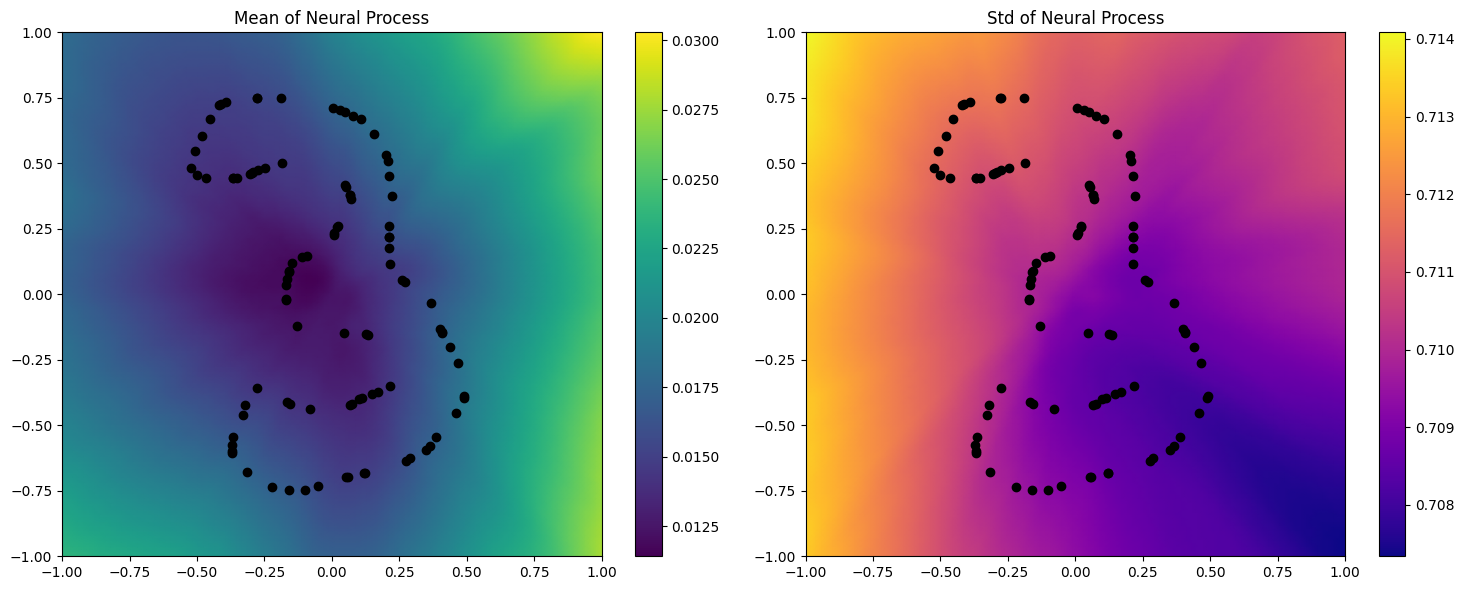

torch.Size([1, 100, 2])


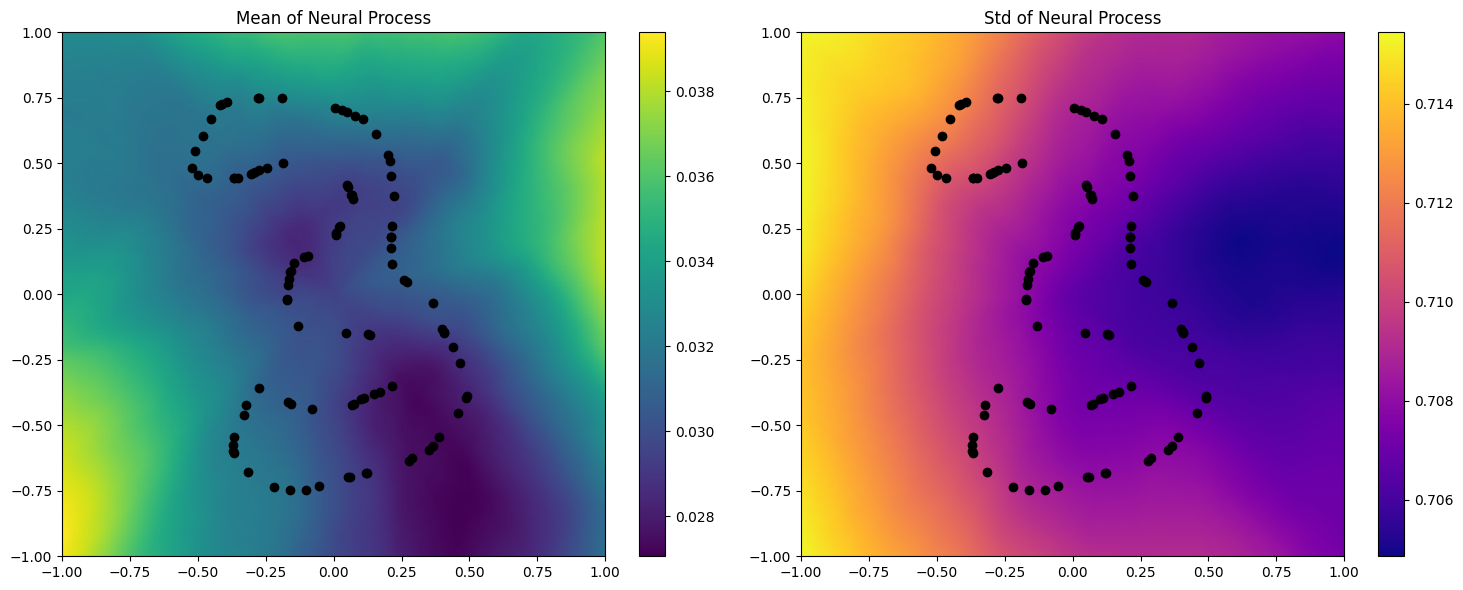

Epoch 0:  18%|███              | 166/938 [01:03<04:19,  2.97batch/s, loss=-67.7]/opt/conda/lib/python3.10/site-packages/gpytoolbox/random_points_on_mesh.py:85: RuntimeWarning: invalid value encountered in divide
  w = l / np.sum(l)
Epoch 0:  18%|███              | 166/938 [01:03<04:19,  2.97batch/s, loss=-67.7]

probabilities contain NaN
6
(3, 2)
[[0.75       0.39366516]
 [0.75       0.39366516]
 [0.75       0.39366516]]
(2, 2)
Skipping invalid item due to: probabilities contain NaN


Epoch 0:  53%|██████▉      | 501/938 [02:57<02:28,  2.95batch/s, loss=-3.18e+10]

Original Label:  tensor(2)
torch.Size([1, 100, 2])


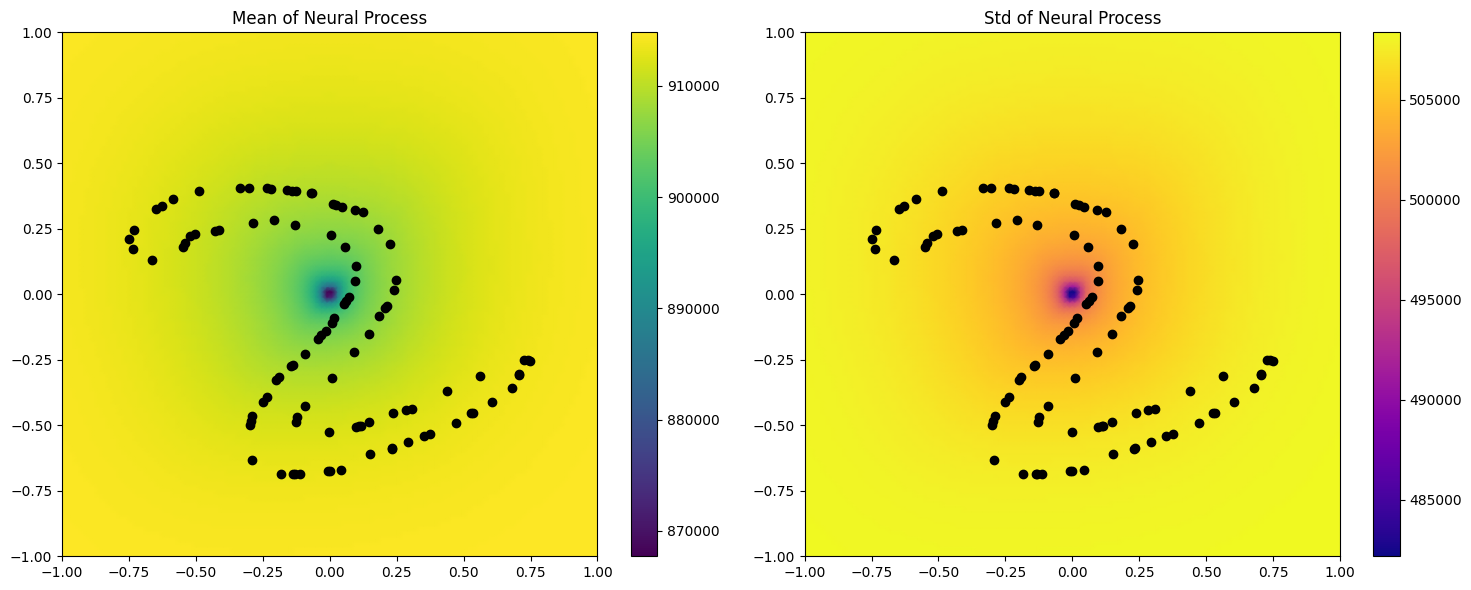

torch.Size([1, 100, 2])


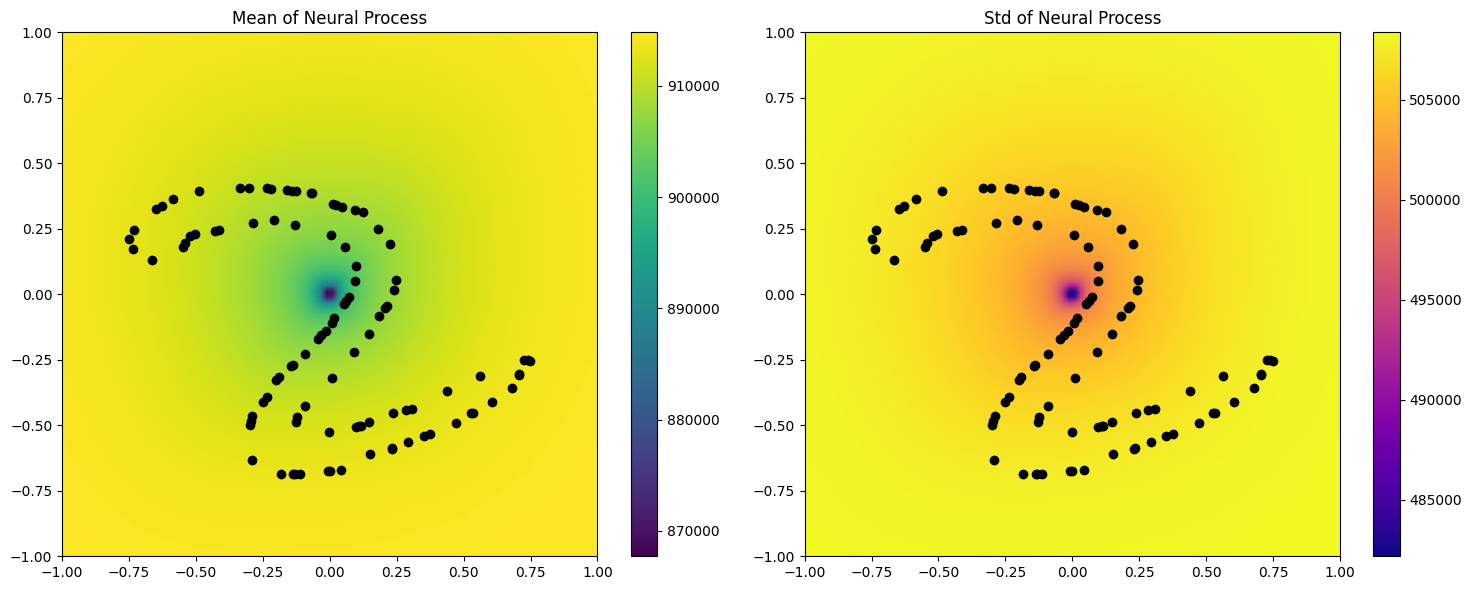

Epoch 0: 100%|█████████████| 938/938 [05:25<00:00,  2.88batch/s, loss=-4.27e+13]


Epoch: 0, Avg_loss: -2.5814895717464596e+18


Epoch 1:   0%|               | 1/938 [00:00<06:27,  2.42batch/s, loss=-5.31e+13]

Original Label:  tensor(0)
torch.Size([1, 100, 2])


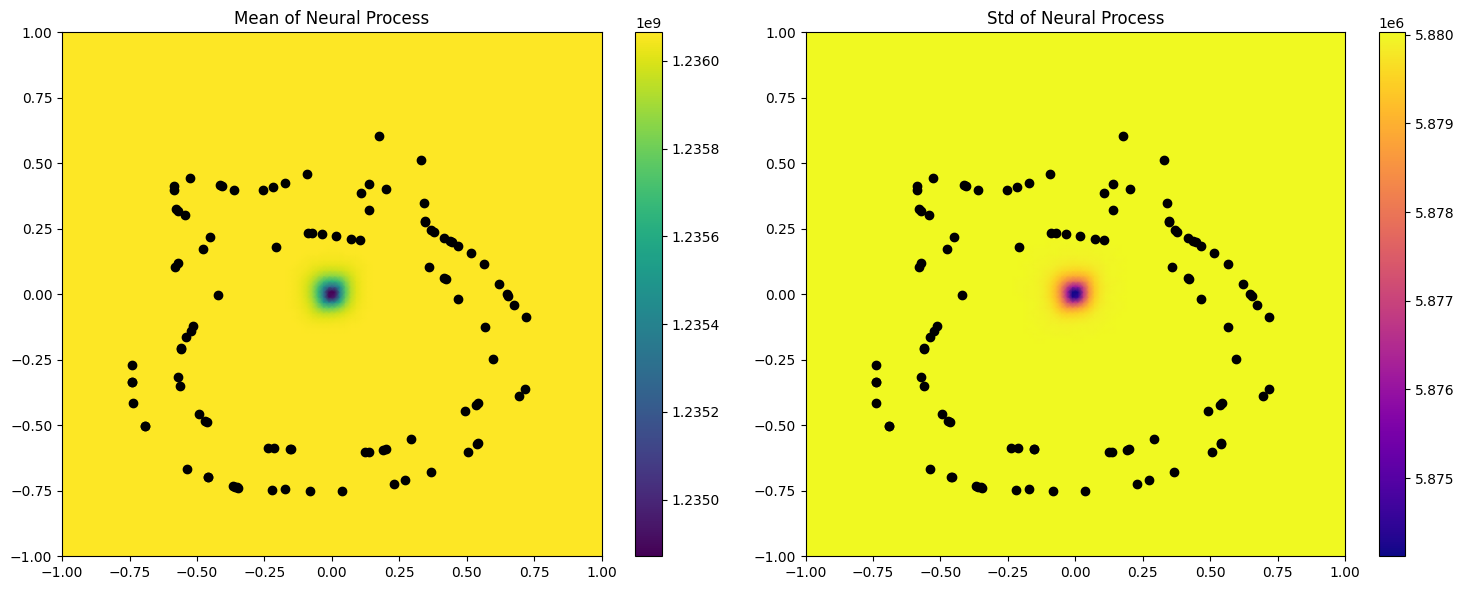

torch.Size([1, 100, 2])


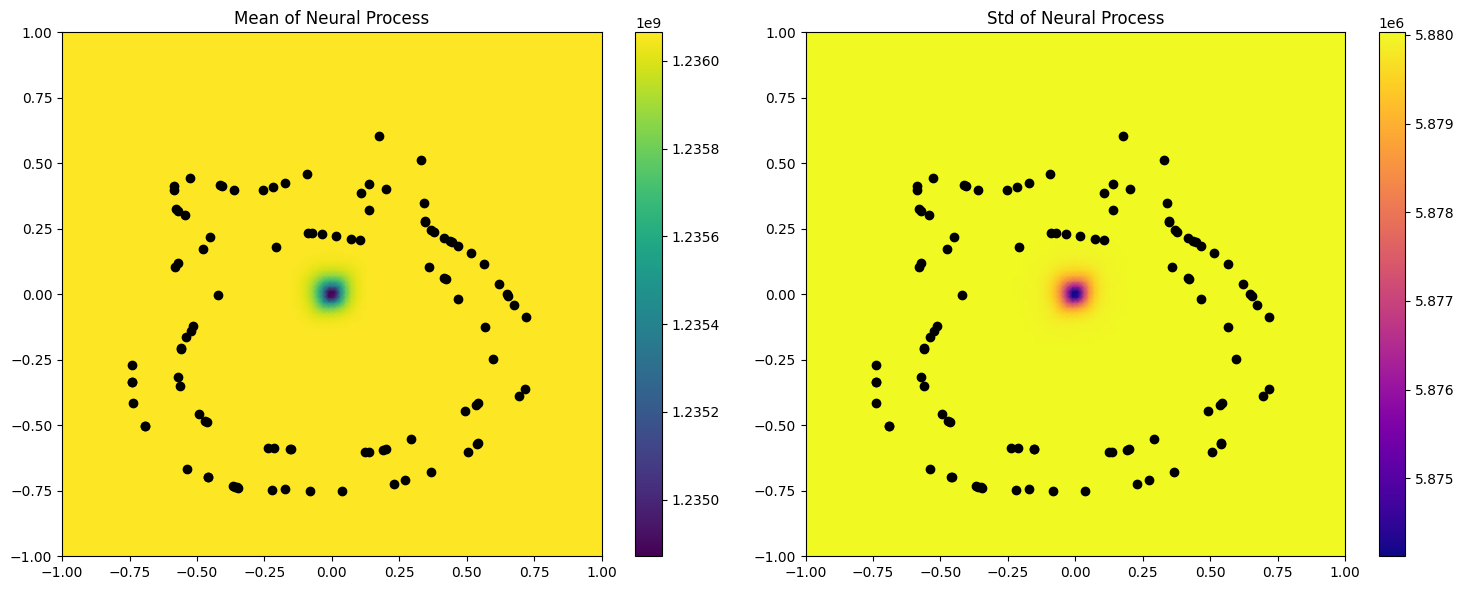

Epoch 1:  29%|███▊         | 276/938 [01:37<03:54,  2.82batch/s, loss=-1.31e+15]


KeyboardInterrupt: 

In [13]:
train(model, optim, train_dataloader,test_dataloader, epochs, n_context, n_target)

Original Label:  tensor(5)
torch.Size([1, 100, 2])


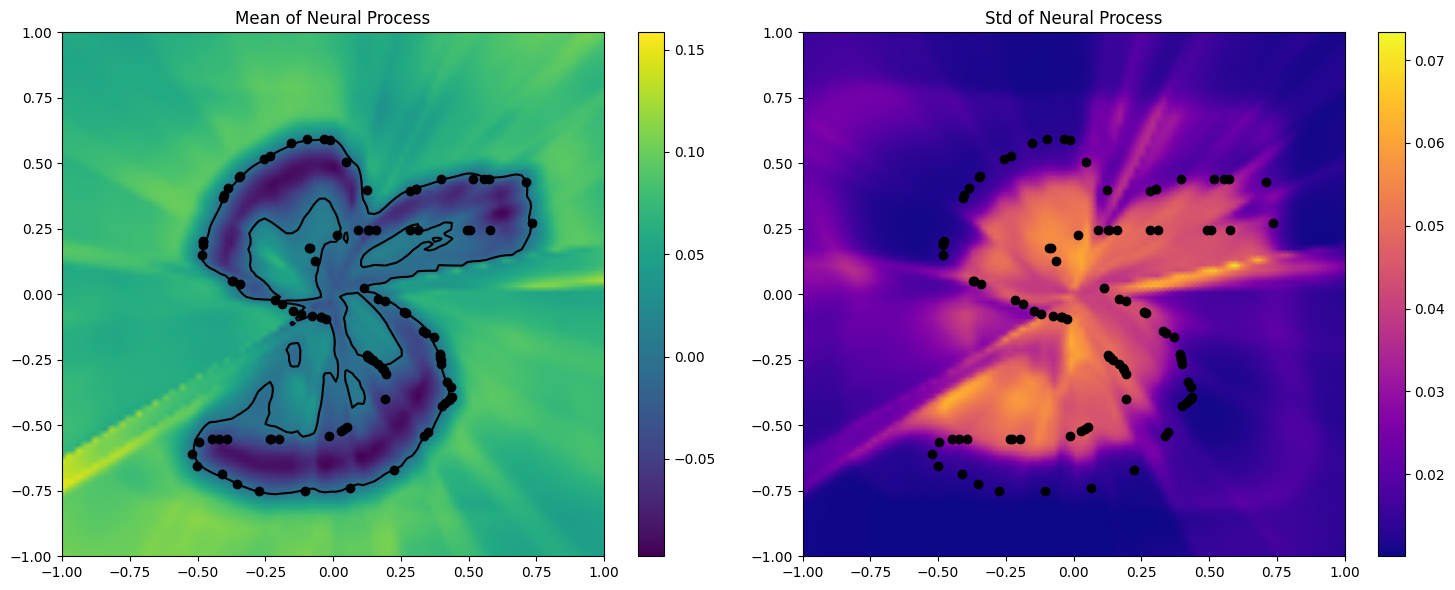

torch.Size([1, 100, 2])


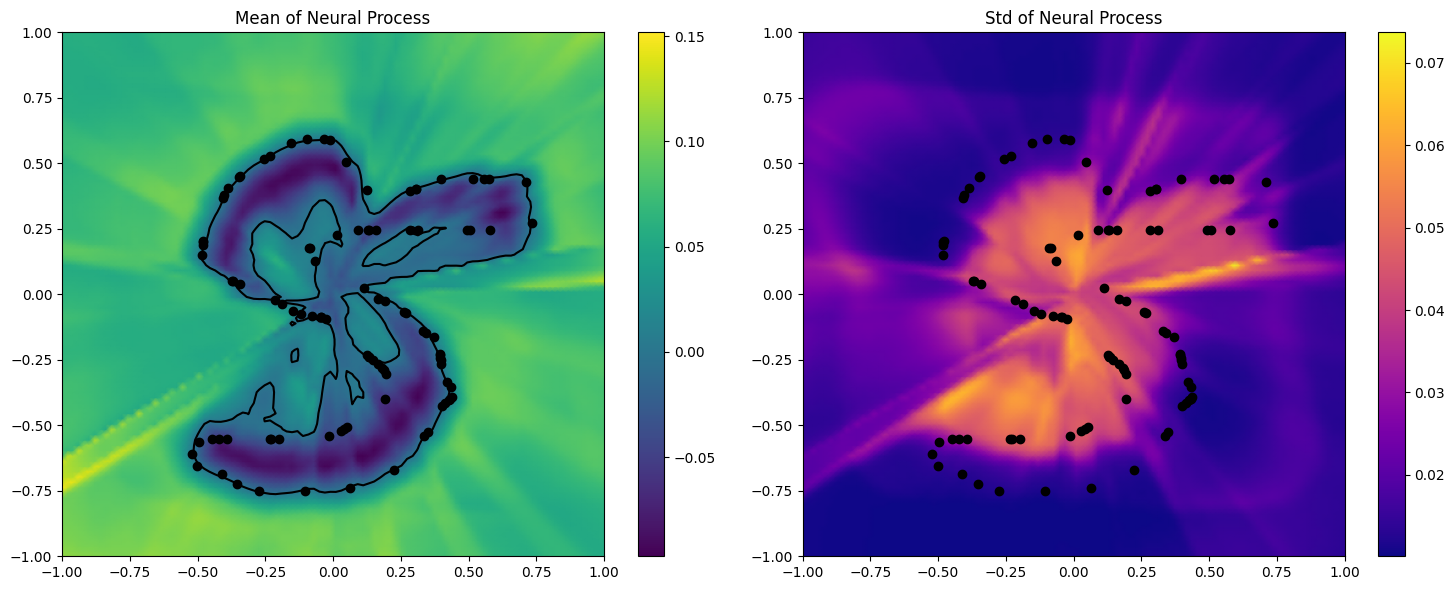

In [44]:
for _ in range(1):
    y_pred, kl, loss, y_std = test(model,test_dataloader, plot=True, size=100)

/tmp/ipykernel_382/2627860310.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_x, context_y = torch.tensor(context_x, dtype=torch.float32), torch.tensor(context_y,dtype=torch.float32)


Original Label:  tensor(1)
N context points:  25
torch.Size([1, 25, 2])


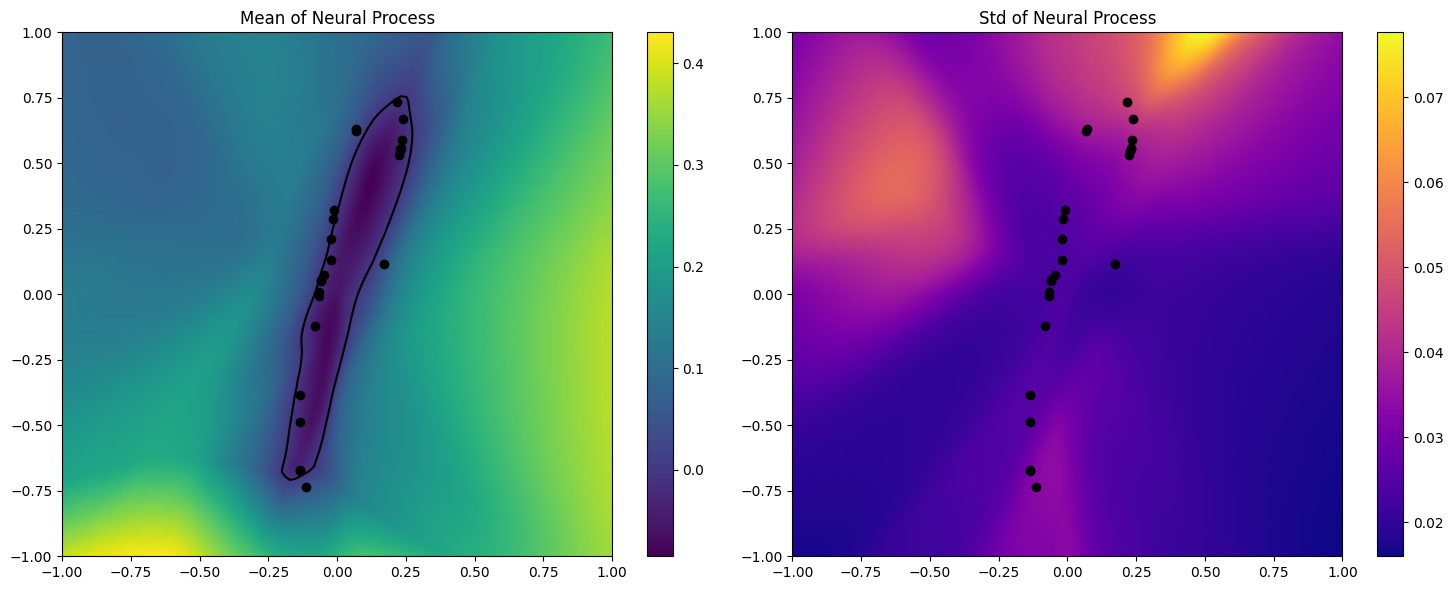

Sample:  0
torch.Size([1, 25, 2])


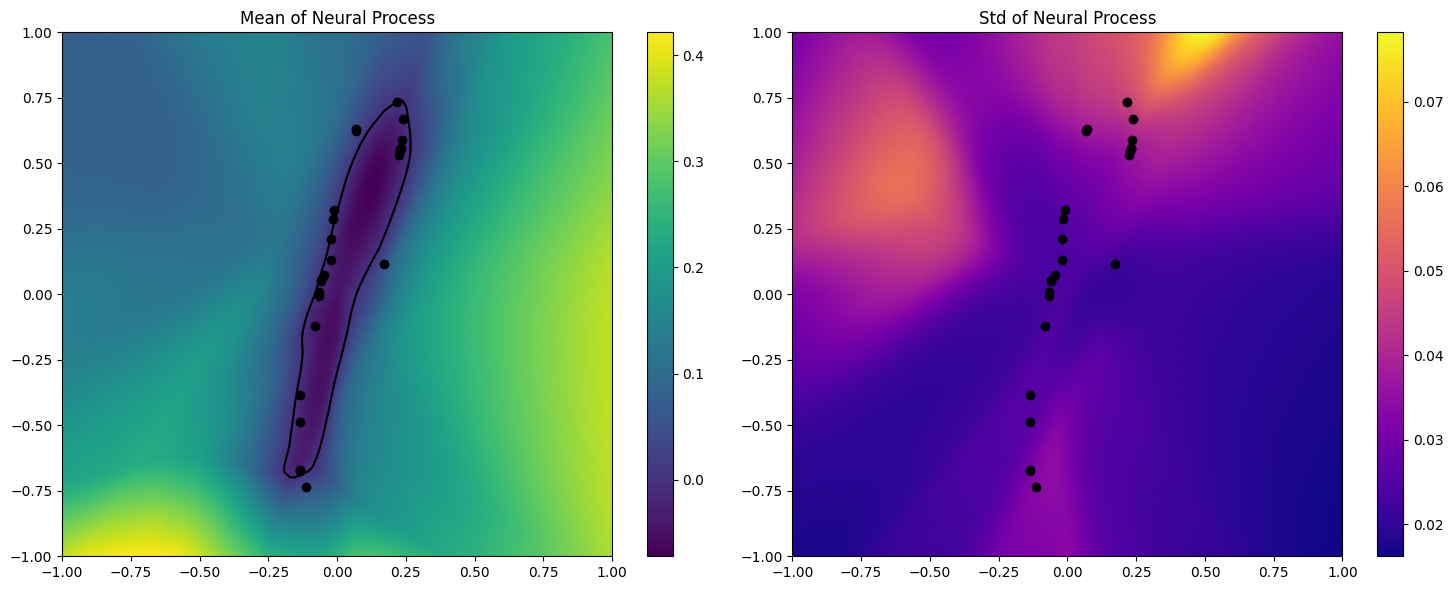

Sample:  1
torch.Size([1, 25, 2])


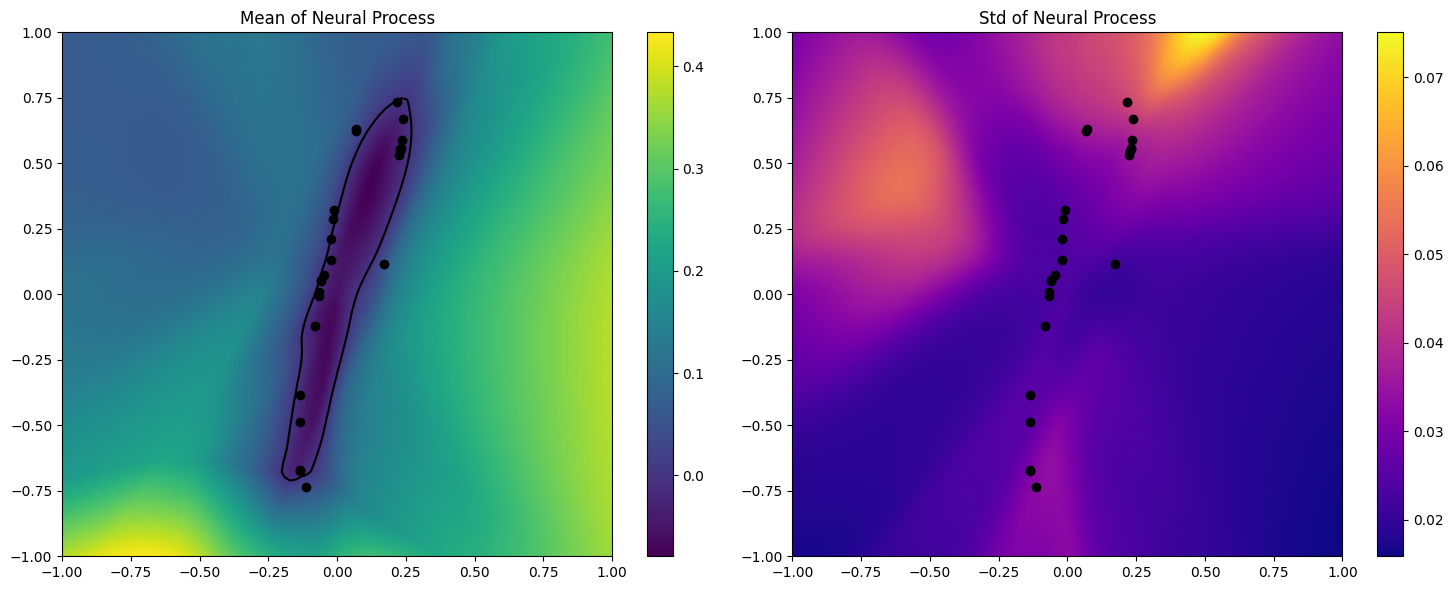

Sample:  2
torch.Size([1, 25, 2])


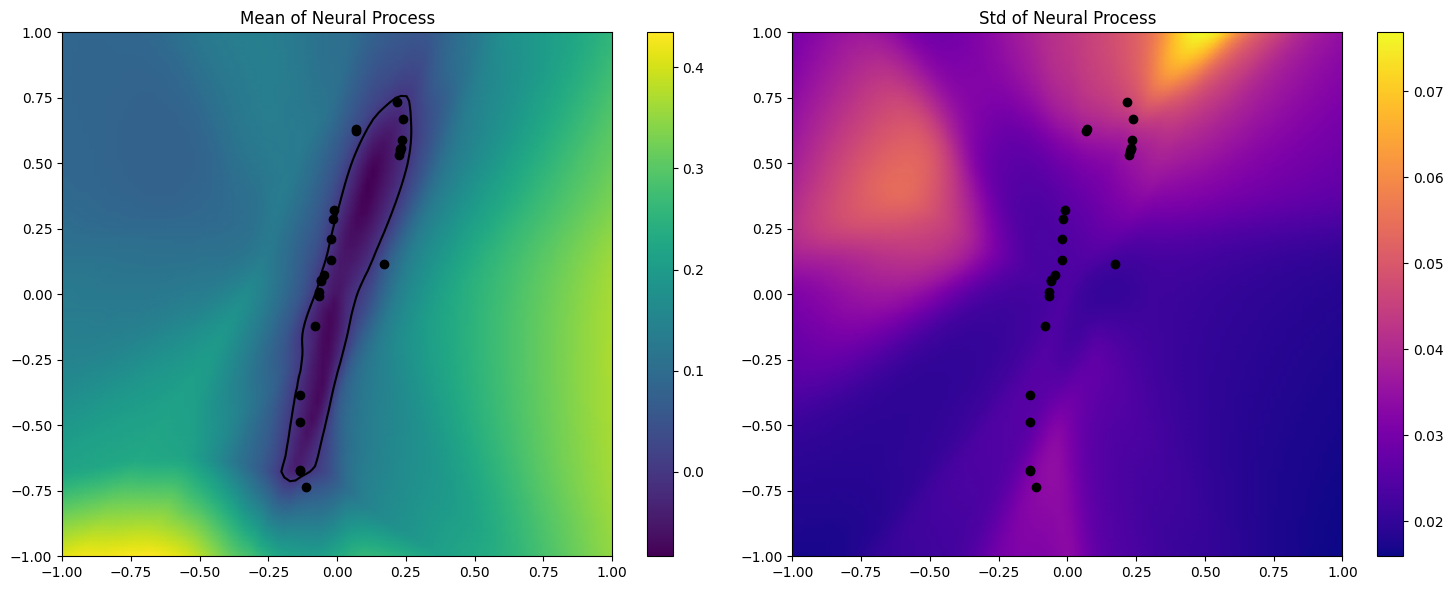

Sample:  3
torch.Size([1, 25, 2])


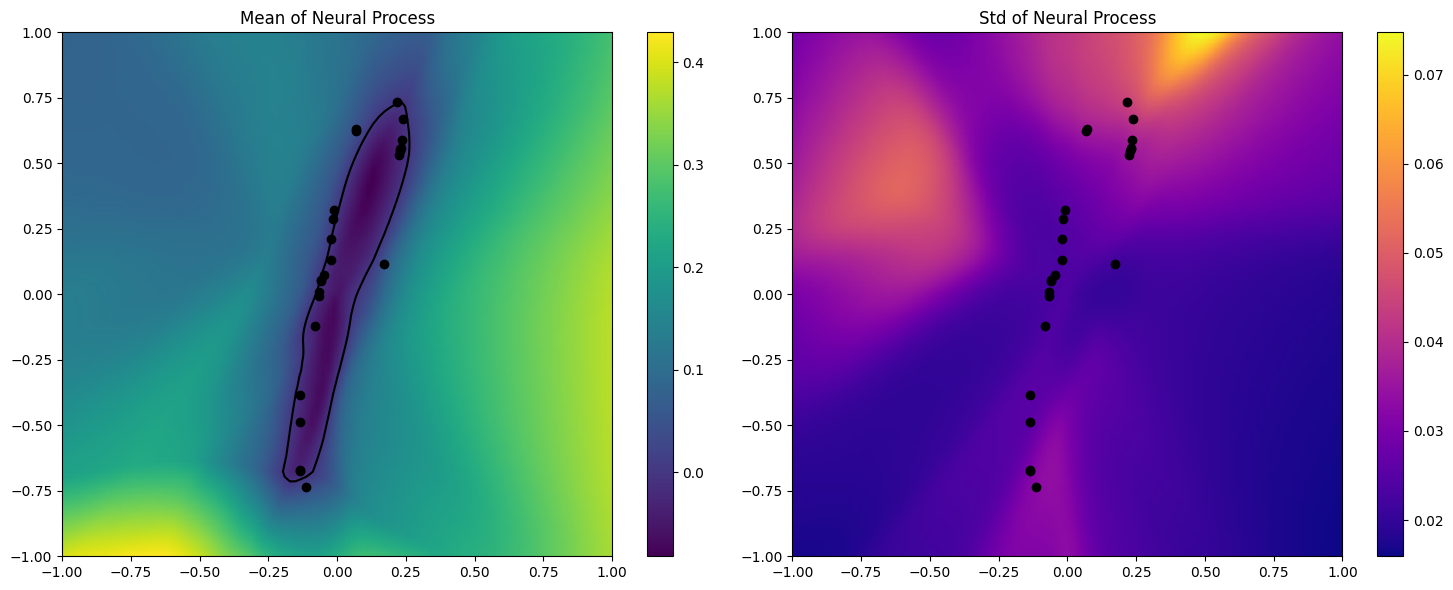

Sample:  4
torch.Size([1, 25, 2])


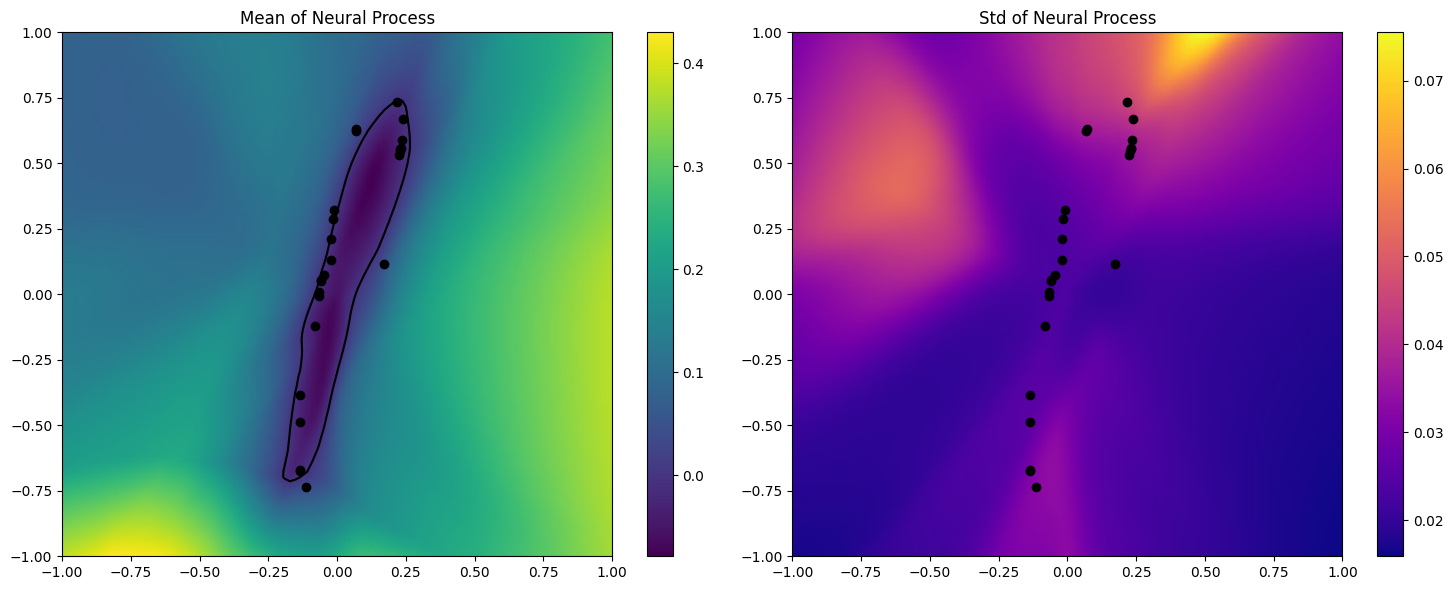

Sample:  5
torch.Size([1, 25, 2])


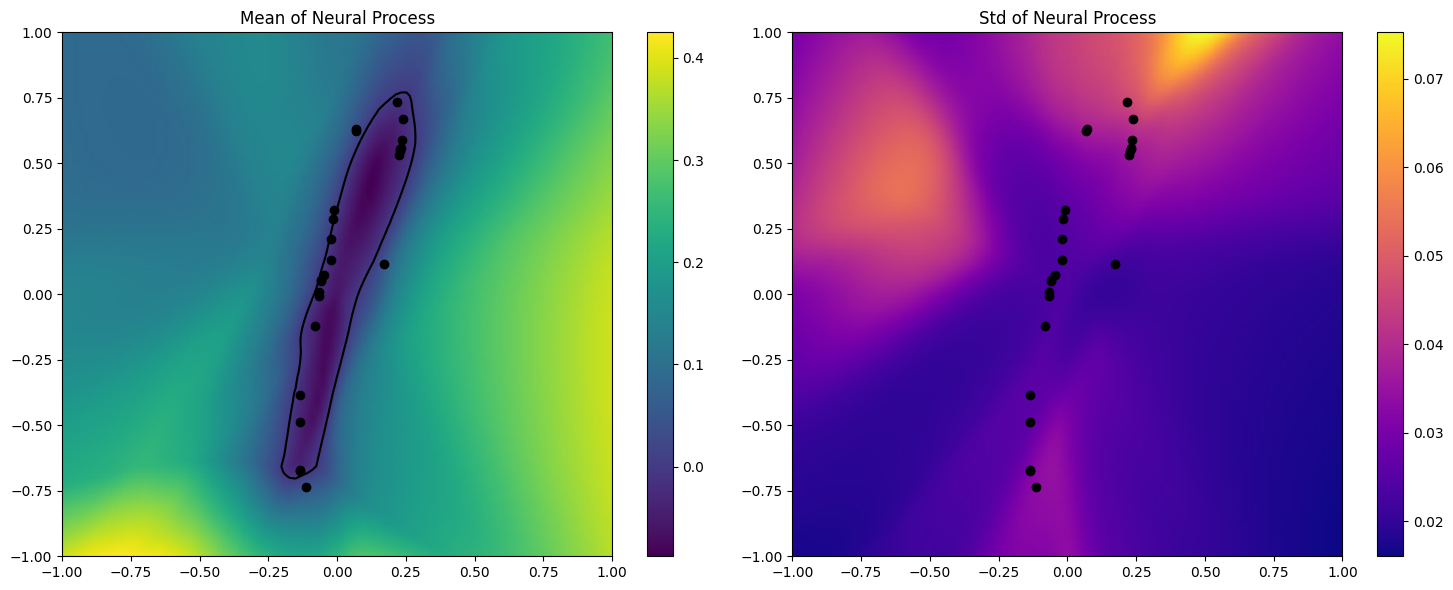

Sample:  6
torch.Size([1, 25, 2])


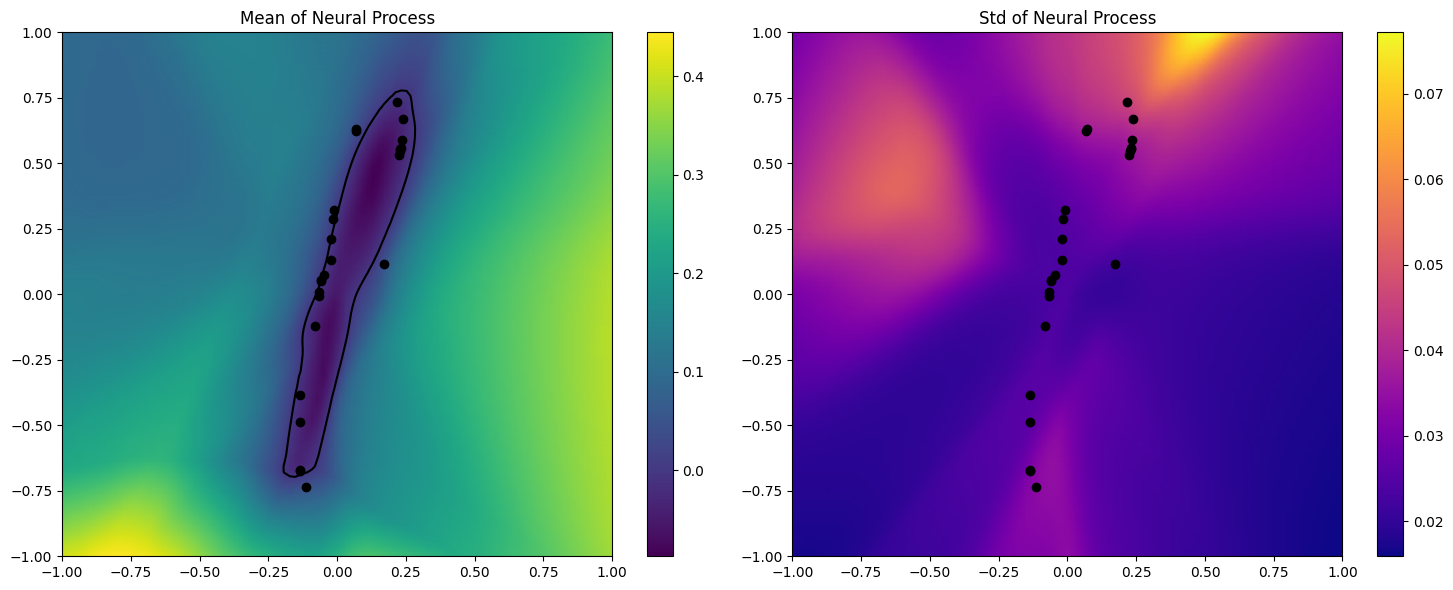

Sample:  7
torch.Size([1, 25, 2])


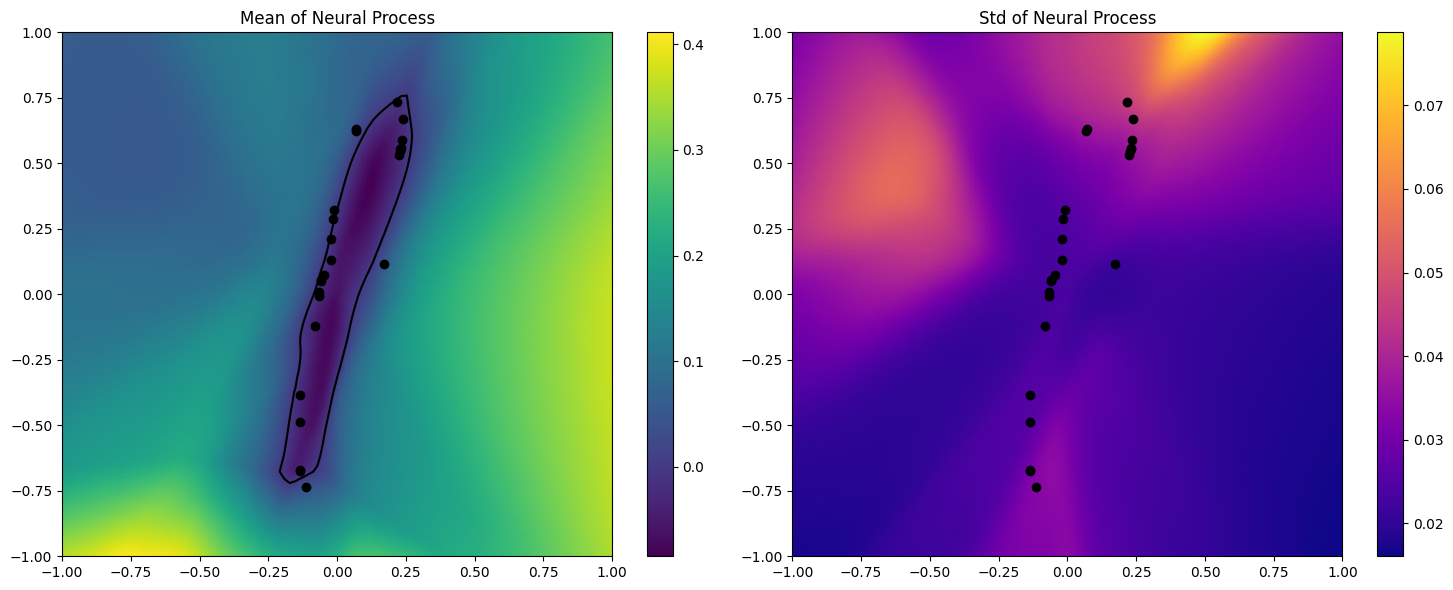

Sample:  8
torch.Size([1, 25, 2])


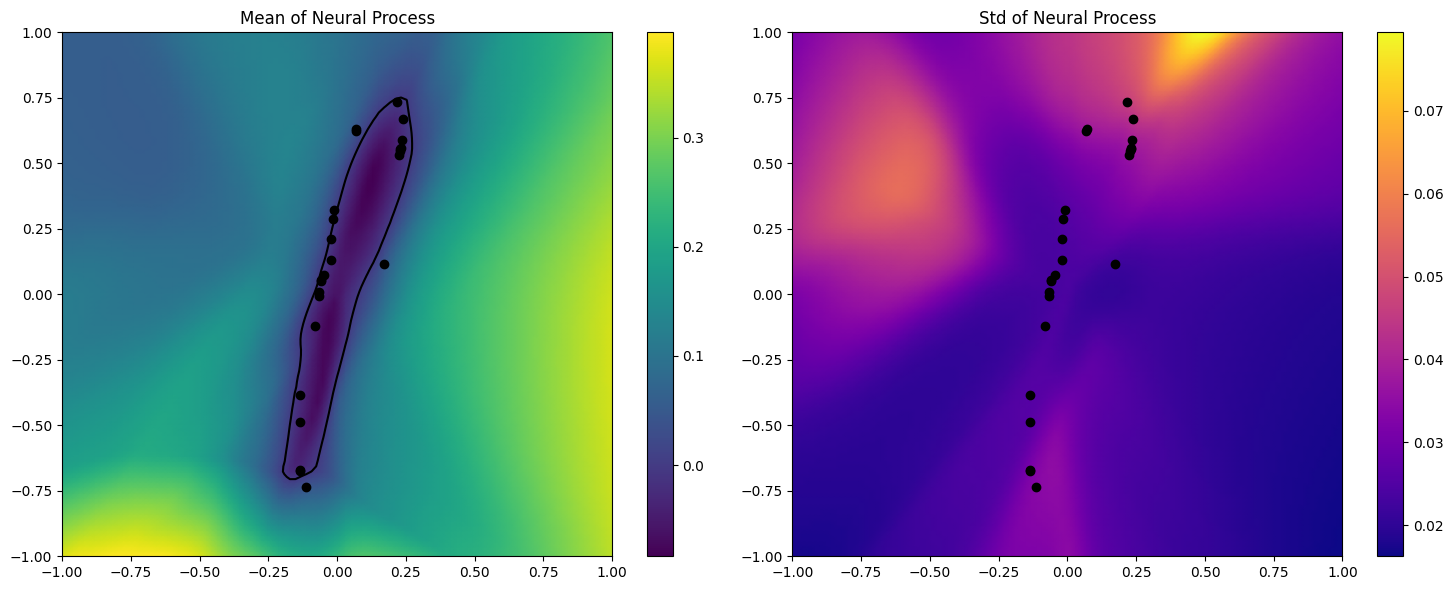

Sample:  9
torch.Size([1, 25, 2])


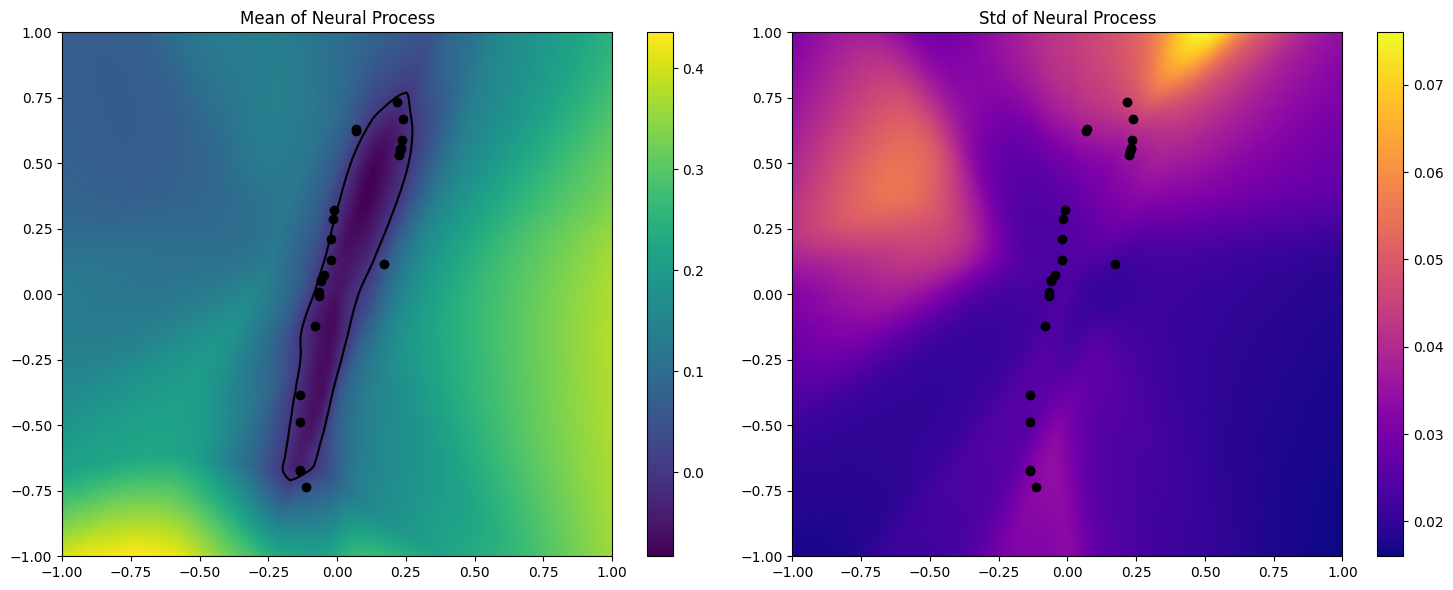

In [31]:
test_progress(model,test_dataloader, plot=True, sizes=[25])